This step processes the .xml file of the annotations and produces a list of polygons (in the form of Shapely objects) extracted from the xml file. 

Annotated polygons are composed of 2 groups, labeled as '_0' and '_2' respectively. Since there are no cited sources on the Camelyon website, we ignored their difference and assumed that both represent polygons that denote 'Cancer'. 

Then, the original is loaded to create tiles, and we check if each tile intersects with any cancerous regions (polygons). We produce a csv file containing the coordinates of the tiles as well as their labels: True means that the tile overlaps with the tumor polygons, False means that the tile does not overlap with a tumor polygon.

# Process XML

In [101]:
pip install shapely

Note: you may need to restart the kernel to use updated packages.


In [102]:
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

from shapely.geometry import box, Polygon
from shapely.ops import cascaded_union
from shapely.strtree import STRtree
from shapely.geometry import MultiPolygon


In [103]:
tree = ET.parse('/Users/jiesun/Dropbox/2021_FALL/DanaFaber/Camelyon/test_046.xml') # TO EDIT if needed

In [104]:
# Convert these into X and Y by annotation groups

def get_coords(tree):
    """
    input: 
        tree: xml ElementTree object
    output: 
        polys: dictionary. key = annotation 0, 1, etc. value = polygon coordinates 
        groups: dictionary. key = annotation 0, 1, etc. value = partofgroup: _0 or _2
    """
    
    
    root = tree.getroot() #root element
    
    polys = {} # key = annotation 0, 1, etc. value = polygon coordinates 
    groups = {} # key = annotation 0, 1, etc. value = partofgroup: _0 or _2

    for item in root.findall('Annotations/Annotation'):

            # initialize for each Annotation group
            x_co = []
            y_co = []
            name = item.get('Name') #retuns: Annotation 0,1,2,...
            group = item.get('PartOfGroup') #returns: _0,_2

            for child in item.findall('Coordinates/Coordinate'):

                x = child.get('X') # returns: 0,1,2,
                x_co.append(x)
                y = child.get('Y') # returns: 0,1,2,
                y_co.append(y)

            # make into list of coords
            x_co = np.array(x_co,dtype=np.float32)
            y_co = np.array(y_co,dtype=np.float32)
            coo = list(zip(y_co,x_co))

            # save into dict
            polys[name] = coo
            groups[name] = group
    
    return polys, groups
    

In [105]:
# transform xml file into 2 dictionaries of polygon coords and annotations
polys, groups = get_coords(tree) 

# Create a group of polygon objects
polygons = [Polygon(polys[k]) for k in polys.keys()]

Below we inspect the content of the three variables: **polys, polygons, groups**

In [106]:
print('Number of polygons in this image:',len(polys))

Number of polygons in this image: 4


In [107]:
print('Overview of groups:',groups) #groups and their labels. _0 does seem to be the one WITH cancer

Overview of groups: {'Annotation 0': '_0', 'Annotation 1': '_0', 'Annotation 2': '_0', 'Annotation 3': '_0'}


In [108]:
# Count: cancer or no cancer? _0 is cancer, _2 is no cancer but within _0
Counter(groups.values()) 

Counter({'_0': 4})

# Load image

In [112]:
import pathml
from pathml import HESlide
from pathml.preprocessing import Pipeline, BoxBlur, TissueDetectionHE

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [113]:
wsi = HESlide("/Users/jiesun/Dropbox/2021_FALL/DanaFaber/Camelyon/test_046.tiff", name = "test_046", backend = 'openslide')

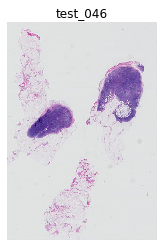

In [114]:
wsi.plot()

In [97]:
wsi.shape

(89600, 61440)

## Helper functions

In [115]:
# 1. check if a tile overlaps with a group of polygons

# before using this, inspect the type of polygons: _0(cancer) or _2(no cancer)
def tile_intersect_polys(query_geom,polygons):
    """
    This function checks if a tile overlaps with a group of polygons.
    query_geom: a polygon object(tile). e.g. Polygon([(30000, 30000), (40000, 30000), (40000, 40000), (30000, 40000)])
    polygons: a list of polygons(tumor). e.g. [Polygon(polys['Annotation 0']),...]
    """
    # create a shapely Tree object, but with query_geom
    s = STRtree([query_geom])
    # Returns a list of all geometries in the s(strtree) whose extents intersect the extent of multiple polygons
    multi = MultiPolygon(polygons)
    result = s.query(multi)
    # does my query_geom intersect with the polygon? True/False
    return query_geom in result

In [116]:
# 2. how to complete the tile coords: input tile initial coord and shape, output a full rectangular

# this will become the input of the query_geom
# output example: [(20000,20000), (30000, 20000), (30000,30000), (20000, 30000)]

def coords_expand(c,s,l):
    """
    c: tile.coords, e.g. (0,0)
    s: tile.shape, e.g. (3000,3000,3)
    l: level
    """
    l = 2**l
    ss = s[0] # e.g. 3000
    ans = [(c[0]*l,c[1]*l),((c[0]+ss)*l,c[1]*l),((c[0]+ss)*l,(c[1]+ss)*l),(c[0]*l,(c[1]+ss)*l)]
    return ans

## Check if tiles intersect with cancer regions

Here we have ignored the different annotation groups and assume that they all represent tumors.

In [117]:
# require previous variable: polygons
LEVEL = 2
SHAPE = 256

p_list = []  # to store a list of  rectangular polygon objects (tile)
p_coords = [] # to store coords of each tile
intersect = [] # to store if each tile intersects with any cancer polygons

for t in wsi.slide.generate_tiles(shape = SHAPE, level = LEVEL): #for each tile
    # generate tiles, make into query_geom
    coo = coords_expand(t.coords,t.shape,LEVEL)
    query_p = Polygon(coo) #tile(a polygon)
    p_coords.append(coo)
    # check if this tile intersect with the polygons
    intersect.append(tile_intersect_polys(query_p,polygons))
    p_list.append(query_p) #list of polygons


In [118]:
print('Number of tiles:',len(p_list))
print('Examples of tile list',p_list[:2])
print('Examples of tile coords',p_coords[:2])
print('Whether tiles intersect with polygons',intersect[:2])
print('How many tiles intersect with polygons:', sum(intersect))

Number of tiles: 5220
Examples of tile list [<shapely.geometry.polygon.Polygon object at 0x7fd2aefbc550>, <shapely.geometry.polygon.Polygon object at 0x7fd2a8876130>]
Examples of tile coords [[(0, 0), (1024, 0), (1024, 1024), (0, 1024)], [(0, 1024), (1024, 1024), (1024, 2048), (0, 2048)]]
Whether tiles intersect with polygons [False, False]
How many tiles intersect with polygons: 18


In [119]:
# export the result
dic = {'tile_coords': p_coords, 'tile_label': intersect}
df = pd.DataFrame(dic)
df.to_csv('/Users/jiesun/Dropbox/2021_FALL/DanaFaber/Camelyon/test_046_tile_labels.csv')

## Plot

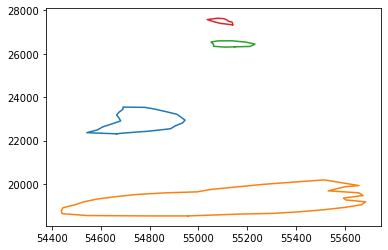

In [99]:
# plot: tumor
for p in polygons:
    plt.plot(*p.exterior.xy)

/var/folders/dv/bvvgqfdx65961yf27jjzsbb00000gn/T/ipykernel_10478/3892797650.py:7: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for t in tiles:


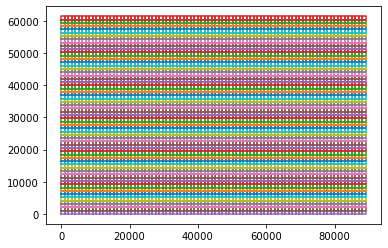

In [100]:
# multipolygon for tiles
tiles = MultiPolygon(p_list)

# plot: tumor with tiles
for p in polygons:
    plt.plot(*p.exterior.xy)
for t in tiles:
    plt.plot(*t.exterior.xy)
# hard to see because too many tiles

In [ ]:
# REF: 
# https://stackoverflow.com/questions/14697442/faster-way-of-polygon-intersection-with-shapely
# https://shapely.readthedocs.io/en/stable/manual.html#polygons